<a href="https://colab.research.google.com/github/bkaradeniz/digit-recognizer-SVHN/blob/master/StatisticalLearning_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.io import loadmat
import numpy as np
from tensorflow.keras.preprocessing.image import random_rotation, random_shift, random_zoom

tfds.disable_progress_bar()
tf.enable_v2_behavior()

# Function definitions

In [ ]:
#cast and normalize the image to [0,1]

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255, label

In [ ]:
#data augmention

def augment(image,label):
  image,label = normalize_img(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) 
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_flip_left_right(image, 5)
  image = tf.image.random_flip_up_down(image, 3)

  return image,label

In [ ]:
#load the dataset and prepare pipelines

def getDataset():
  (ds_train, ds_test), ds_info = tfds.load(
      'svhn_cropped',
      split=['extra', 'test'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True)
  return ds_train, ds_test, ds_info

def getTrain(ds_train):
  ds_train = ds_train.map(
      normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #ds_train = ds_train.cache()
  ds_train = ds_train.shuffle(ds_info.splits['extra'].num_examples)
  ds_train = ds_train.batch(800)
  ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
  return ds_train

def getTest(ds_test):
  ds_test = ds_test.map(
      normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.batch(800)
  ds_test = ds_test.cache()
  ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
  return ds_test

def getAugmented(ds_train):  
  ds_train_aug = ds_train.map(
      normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #ds_train_aug = ds_train_aug.cache()
  ds_train_aug = ds_train_aug.map(
      augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_train_aug = ds_train_aug.shuffle(ds_info.splits['extra'].num_examples)
  ds_train_aug = ds_train_aug.batch(800)
  ds_train_aug = ds_train_aug.prefetch(tf.data.experimental.AUTOTUNE)
  return  ds_train_aug

# Feedforward network prep and results

In [ ]:
#create the feedforward model

model1 = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(120),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dense(60),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(10, activation='softmax')
      ])

In [ ]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'])


**Load the dataset**

In [ ]:
ds_train, ds_test, ds_info = getDataset()

In [ ]:
#prepare data

ds_train = getTrain(ds_train)
ds_test = getTest(ds_test)

**Run for 15 Epochs**

In [ ]:
history = model1.fit(ds_train, epochs=15 ,validation_data = ds_test)

Epoch 1/15
664/664 [==============================] - 18s 28ms/step - loss: 0.7664 - accuracy: 0.7622 - val_loss: 0.6676 - val_accuracy: 0.7986
Epoch 2/15
664/664 [==============================] - 12s 17ms/step - loss: 0.4180 - accuracy: 0.8724 - val_loss: 0.5783 - val_accuracy: 0.8248
Epoch 3/15
664/664 [==============================] - 11s 16ms/step - loss: 0.3586 - accuracy: 0.8911 - val_loss: 0.5228 - val_accuracy: 0.8441
Epoch 4/15
664/664 [==============================] - 11s 17ms/step - loss: 0.3289 - accuracy: 0.8999 - val_loss: 0.5238 - val_accuracy: 0.8449
Epoch 5/15
664/664 [==============================] - 11s 16ms/step - loss: 0.3095 - accuracy: 0.9058 - val_loss: 0.5005 - val_accuracy: 0.8530
Epoch 6/15
664/664 [==============================] - 11s 17ms/step - loss: 0.2959 - accuracy: 0.9101 - val_loss: 0.4775 - val_accuracy: 0.8564
Epoch 7/15
664/664 [==============================] - 11s 17ms/step - loss: 0.2848 - accuracy: 0.9140 - val_loss: 0.4507 - val_accuracy:

**Line graphs for validation and loss**

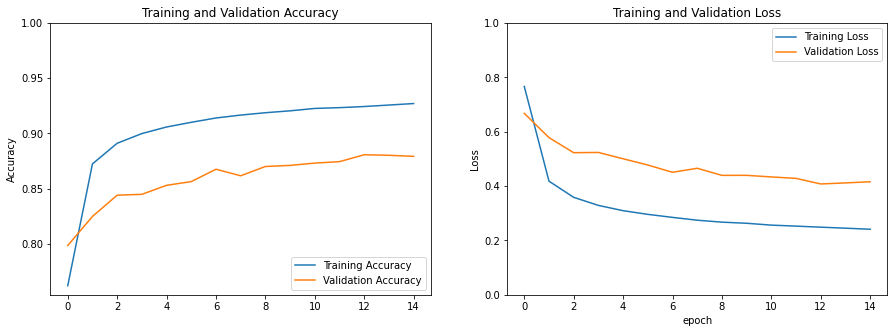

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print("CNN model1: Epochs=15, Train accuracy={0:.5f}, Validation accuracy={1:.5f}".format(
        max(history.history['accuracy']),max(history.history['val_accuracy']) ))

# Convolutional Neural Net

In [ ]:
#create the model

model2 = models.Sequential(name='model2')

model2.add(layers.Conv2D(32,kernel_size=3,activation='relu',input_shape=(32,32,3)))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32,kernel_size=3, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same', activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.2))

model2.add(layers.Conv2D(64,kernel_size=3, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64,kernel_size=3, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64,kernel_size=5,strides=2,padding='same', activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.2))

model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(10, activation='softmax'))

In [ ]:
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'])

In [ ]:
#Prepare data for non-augmented run

ds_train, ds_test, ds_info = getDataset()  

ds_train = getTrain(ds_train) 
ds_test = getTest(ds_test)                  

**Apply with 15 epochs**

In [ ]:
history2 = model2.fit(ds_train, epochs=15, validation_data = ds_test)

Epoch 1/15
664/664 [==============================] - 110s 166ms/step - loss: 0.2328 - accuracy: 0.9302 - val_loss: 0.2249 - val_accuracy: 0.9371
Epoch 2/15
664/664 [==============================] - 104s 156ms/step - loss: 0.0932 - accuracy: 0.9739 - val_loss: 0.2000 - val_accuracy: 0.9461
Epoch 3/15
664/664 [==============================] - 104s 156ms/step - loss: 0.0738 - accuracy: 0.9799 - val_loss: 0.1789 - val_accuracy: 0.9530
Epoch 4/15
664/664 [==============================] - 103s 156ms/step - loss: 0.0641 - accuracy: 0.9825 - val_loss: 0.1617 - val_accuracy: 0.9587
Epoch 5/15
664/664 [==============================] - 103s 156ms/step - loss: 0.0582 - accuracy: 0.9842 - val_loss: 0.1715 - val_accuracy: 0.9548
Epoch 6/15
664/664 [==============================] - 103s 156ms/step - loss: 0.0528 - accuracy: 0.9857 - val_loss: 0.1443 - val_accuracy: 0.9646
Epoch 7/15
664/664 [==============================] - 103s 155ms/step - loss: 0.0488 - accuracy: 0.9868 - val_loss: 0.1462 -

**Line graphs for accuracy and loss**

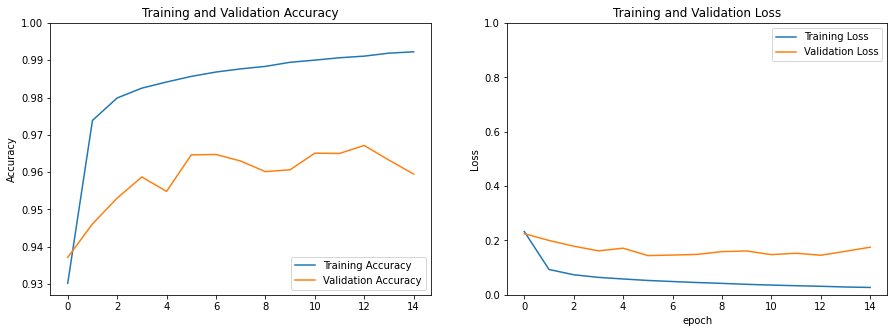

CNN model2: Epochs=15, Train accuracy=0.92708, Validation accuracy=0.88072


In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print("CNN model2: Epochs=15, Train accuracy={0:.5f}, Validation accuracy={1:.5f}".format(
        max(history.history['accuracy']),max(history.history['val_accuracy']) ))

# Data Augmentation

In [ ]:
#create the model

model3 = models.Sequential(name='model2')

model3.add(layers.Conv2D(32,kernel_size=3,activation='relu',input_shape=(32,32,3)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(32,kernel_size=3, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same', activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(64,kernel_size=3, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(64,kernel_size=3, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(64,kernel_size=5,strides=2,padding='same', activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.2))

model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(10, activation='softmax'))

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'])

In [ ]:
#prepare data

ds_train, ds_test, ds_info = getDataset()  

ds_train_aug = getAugmented(ds_train)
ds_test = getTest(ds_test)  


**Apply with augmented data**

In [ ]:
history3 = model3.fit(ds_train_aug, epochs=15, validation_data = ds_test)

Epoch 1/15
664/664 [==============================] - 110s 165ms/step - loss: 2.3471 - accuracy: 0.1461 - val_loss: 3.0968 - val_accuracy: 0.1924
Epoch 2/15
664/664 [==============================] - 102s 153ms/step - loss: 2.2692 - accuracy: 0.1639 - val_loss: 2.3402 - val_accuracy: 0.1287
Epoch 3/15
664/664 [==============================] - 102s 154ms/step - loss: 2.2619 - accuracy: 0.1679 - val_loss: 5.3632 - val_accuracy: 0.1600
Epoch 4/15
664/664 [==============================] - 101s 153ms/step - loss: 2.2609 - accuracy: 0.1683 - val_loss: 3.5970 - val_accuracy: 0.1021
Epoch 5/15
664/664 [==============================] - 102s 153ms/step - loss: 2.2600 - accuracy: 0.1682 - val_loss: 2.8729 - val_accuracy: 0.1366
Epoch 6/15
664/664 [==============================] - 102s 153ms/step - loss: 2.2593 - accuracy: 0.1684 - val_loss: 2.2991 - val_accuracy: 0.1318
Epoch 7/15
664/664 [==============================] - 101s 153ms/step - loss: 2.2589 - accuracy: 0.1693 - val_loss: 2.2867 -

**Line graphs for augmented experiment**

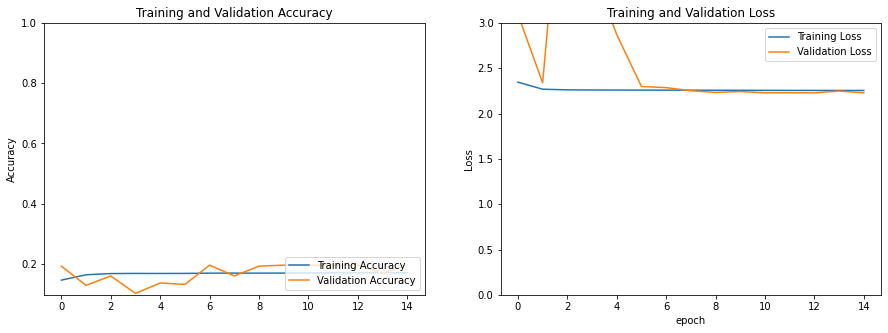

CNN-Augmented model3: Epochs=15, Train accuracy=0.92708, Validation accuracy=0.88072


In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print("CNN-Augmented model3: Epochs=15, Train accuracy={0:.5f}, Validation accuracy={1:.5f}".format(
        max(history.history['accuracy']),max(history.history['val_accuracy']) ))

**Line graphs for comparison between augmented & non-augmented data**

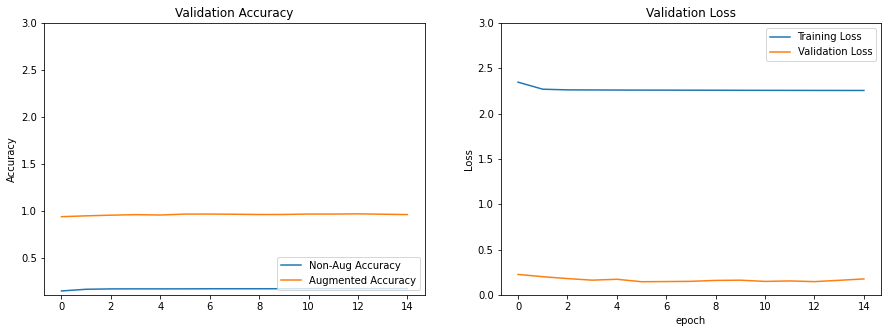

In [ ]:
val_acc = history2.history['val_accuracy']
val_acc_aug = history3.history['val_accuracy']

val_loss = history2.history['val_loss']
val_loss_aug = history3.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Non-Aug Accuracy')
plt.plot(val_acc, label='Augmented Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),3])
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,3.0])
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

# Prediction comparions between Feedforward and Convolutional models

In [ ]:
predictions1 = np.argmax(model1.predict(ds_test), axis=-1)
predictions1

array([2, 7, 2, ..., 3, 5, 1])

In [ ]:
predictions2 = np.argmax(model1.predict(ds_test), axis=-1)
predictions2

array([2, 7, 2, ..., 3, 5, 1])

In [ ]:
predBool = predictions1 == predictions2
numTrue = 0
numFalse = 0

for elem in predBool:
  if elem == True:
    numTrue = numTrue + 1
  else:
    numFalse = numFalse + 1

matching = numTrue / (numTrue + numFalse)
print("The amount of match within predictions of two models:{0:.5f}".format(matching))

The amount of match within predictions of two models:0.87876
